In [ ]:
!cd ..
!pwd

/content


In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt



# LSTM Neural networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

dt:"temperature",dws:"wind",dwd:"winddir",drr:"rainfall",dm:"pressure",dh:"humidity",ds:"snow",dwc:"weather_code"

In [ ]:
data = pd.read_csv("./weer_no2.csv")
data['time']=data["Unnamed: 0"]
weerdata = data.set_index('time').drop("Unnamed: 0",axis=1)
weerdata.corr() # --> Gives correlations .cov() gives covariance
weerdata.head()

,dt,dws,dwd,drr,dm,dh,no2
time,,,,,,,
2017-12-01,0.150000,0.036364,228.636364,0.253333,1022.454545,95.833333,65.5
2017-12-02,-1.604167,0.433043,195.913043,0.000000,1027.826087,96.958333,125.5
2017-12-03,1.479167,0.680000,225.083333,0.275000,1026.975000,97.291667,43.5
2017-12-04,5.395833,0.277917,234.875000,0.052083,1033.020833,96.666667,57.0
2017-12-05,6.708333,0.819130,230.608696,0.000000,1035.934783,87.166667,50.0


# Toy Problem

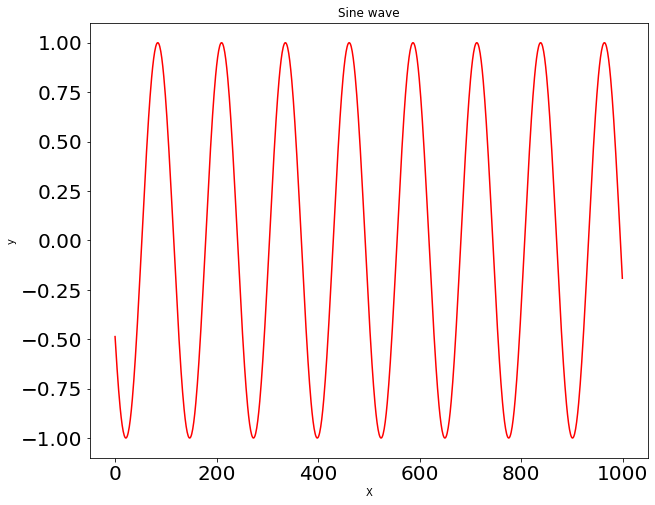

In [ ]:
N = 100
L =1000
T = 20

x = np.empty((N,L),np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T,4*T,N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize=[10,8])
plt.title("Sine wave")
plt.xlabel("X")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]),y[0,:],"r")

## Defining the predictor

In [ ]:
class LSTMPredictor(nn.Module):
  def __init__(self,n_hidden=51):
    super(LSTMPredictor,self).__init__()
    self.n_hidden = n_hidden
    # lstm1, lstm2, linear (to predict we have linear)
    
    self.n_features = n_features
    self.seq_len = seq_length
    self.n_hidden = 20 # number of hidden states
    self.n_layers = 1 # number of LSTM layers (stacked)
    
    self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
    self.linear =linear(torch.nn.Linear(self.n_hidden*self.seq_len, 1))

  def forward(self, x, future=0):
    # future is future value: amount of future values we want to predict
    # 0 if we train
    outputs = []
    n_samples = x.size(0)

    # initial hidden states
    h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)  
    c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)   # initial cell state
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)   # initial hidden state 2
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)   # initial cell state 2
   
    for input_t in x.split(1,dim=1):
      # Splits tensors into single value chuncks!
      # call first layer, calculate cell ouput + new  hidden state
      h_t , c_t = self.lstm1(input_t,(h_t,c_t))
      h_t2 , c_t2 = self.lstm2(h_t,(h_t2,c_t2)) # calculates based on hidden state from previous
      output = self.linear(h_t2)
      outputs.append(output)

    # future predictions, if future is 0, no prediction
    for i in range(future):
      h_t , c_t = self.lstm1(output,(h_t,c_t)) # input here is last output from training
      h_t2 , c_t2 = self.lstm2(h_t,(h_t2,c_t2)) # calculates based on hidden state from previous
      output = self.linear(h_t2)
      outputs.append(output)

    # put outputs in tensor
    outputs = torch.cat(outputs,dim=1)
    return outputs


## Defining the inputs

In [ ]:
# y = 100, 1000
train_input = torch.from_numpy(y[3:,:-1]) # 97, 999
train_target = torch.from_numpy(y[3:,1:]) # 97,999

test_input = torch.from_numpy(y[:3,:-1]) # 3,999
test_target = torch.from_numpy(y[:3,1:]) # 3,999

model = LSTMPredictor()
criterion = nn.MSELoss()

optimizer = optim.LBFGS(model.parameters(), lr=0.8) # instead of ADAM
# Can work on whole data! Needs to have a function 

n_steps = 10
for i in range(n_steps):
  print("step", i)
  
  def closure():
    # empty gradients, apply forward and backward step and criterion
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out,train_target)
    print("loss", loss.item())
    loss.backward()
    return loss
  
  optimizer.step(closure)
  
  with torch.no_grad():
    future = 1000
    pred = model(test_input,future=future)
    loss = criterion(pred[:,:-future],test_target)
    print("loss", loss.item())
    y = pred.detach().numpy()

  plt.figure(figsize=[12,6])
  plt.title(f"Step{i+1}")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = train_input.shape[1] # 999
  def draw(y_i,color):
    plt.plot(np.arange(n),y_i[:n],color)
    plt.plot(np.arange(n,n+future),y_i[n:],color+":")

  draw(y[0],"r")
  draw(y[1],"b")
  draw(y[2],"g")
    

NameError: ignored

# NO2 prediction

## Data loading

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import pandas as pd
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# read weatherdata
data = pd.read_csv("./weer_no2.csv")
data['time']=data["Unnamed: 0"]
data = data.set_index('time').drop(["Unnamed: 0","dm"],axis=1) # Luchtdruk eens weggelaten
print(data.head())
print(data.shape)

data["no2"].plot()
weerdata = data

FileNotFoundError: ignored

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
# weerdata transformeren --> to training_data

training_data = weerdata.values
print(training_data.shape)
training_data = sc.fit_transform(training_data)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))).cuda()
dataY = Variable(torch.Tensor(np.array(y))).cuda()

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).cuda()
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).cuda()

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).cuda()
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).cuda()


In [ ]:
# Check data
print(testX.size())
testX.view(-1,7)

# Hidden Markov Model


In [ ]:
!pip install hmmlearn

In [ ]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [ ]:
def plot_states(ts_vals, states, time_vals):
    
    fig, ax1 = plt.subplots(1,1,figsize=[25,7], dpi= 80)
    

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('$\mu$g/$m^3$', color=color)
    ax1.plot(time_vals, ts_vals, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

In [ ]:
no2 = data["no2"]
no2.head

In [ ]:
hidden_states, mus, sigmas, transmat, model = fitHMM(no2.values, 3)

NameError: ignored

In [ ]:
plot_states(no2.values, hidden_states, no2.index)

NameError: ignored

In [ ]:
print(transmat)

NameError: ignored

## LSTM model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout=0) # dropout staat uit
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out[1].view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## adapting data

In [ ]:
num_epochs = 1000
learning_rate = 0.05

input_size = 6
hidden_size = 10
num_layers = 2

num_classes = 6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
ltsm = lstm.cuda()
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
lstm.train()
losses = []
epochs = []
for m in lstm.parameters():
  print(m.device)

for epoch in range(num_epochs):
    trainX = trainX
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    
    losses.append(loss.item())
    epochs.append(epoch)

    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

plt.plot(epochs,losses)
plt.title('MSE loss in function of Epoch')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

NameError: ignored

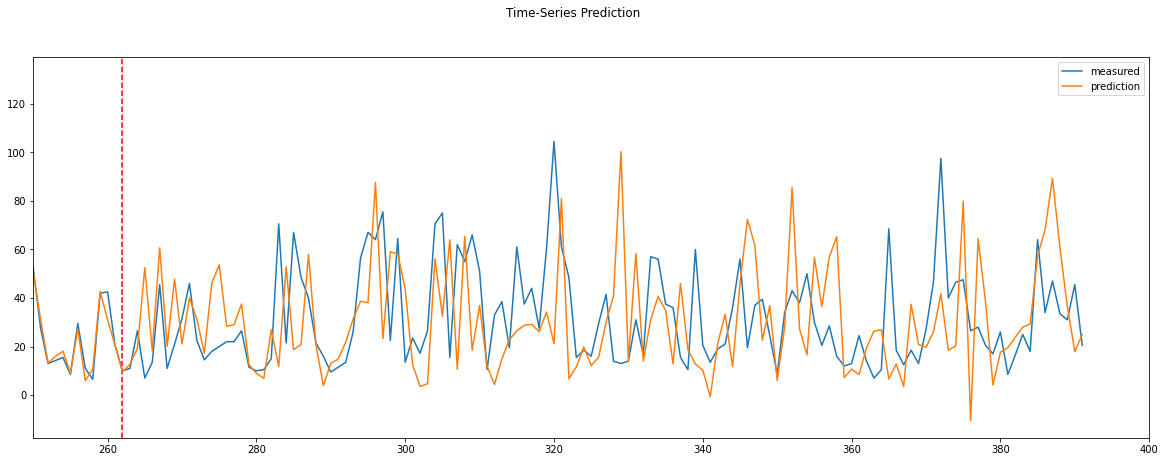

In [ ]:
lstm.eval()
train_predict = lstm(dataX).cpu()

data_predict = train_predict.data.numpy()
dataY_plot = dataY.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=[20,7])
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot[:,-1],label="measured")
plt.plot(data_predict[:,-1],label="prediction")
plt.suptitle('Time-Series Prediction')
plt.xlim([250,400])
plt.legend()
plt.show()
